### 1. Import libraries and get data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv("./USDT.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')

# Format the 'Date' column in the 'dd-mm-yyyy' format
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df

,Price
Date,
2017-12-01,1.0100
2017-12-02,0.9959
2017-12-03,0.9977
2017-12-04,1.0000
2017-12-05,1.0000
...,...
2023-03-28,1.0001
2023-03-29,0.9999
2023-03-30,1.0000


In [48]:
# Split the data into training (70%) and test (30%) sets
train_size = int(0.7 * len(df))

train = df[:train_size]
test = df[train_size:]

# Check the sizes of the data sets
print("Train shape:", train.shape)
print("Test shape:", test)

Train shape: (1362, 1)
Test shape:              Price
Date              
2021-08-25  1.0002
2021-08-26  1.0003
2021-08-27  1.0006
2021-08-28  1.0006
2021-08-29  1.0007
...            ...
2023-03-28  1.0001
2023-03-29  0.9999
2023-03-30  1.0000
2023-03-31  1.0001
2023-04-01  1.0002

[585 rows x 1 columns]


### 2. Find the order of differencing (d) in ARIMA model 

- First, I will check if the series is stationary using the Augmented Dickey Fuller test (ADF Test), from the statsmodels package. The reason being is that we need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.

- The null hypothesis (Ho) of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series is indeed stationary.

In [4]:
from statsmodels.tsa.stattools import adfuller
print('p-value:', adfuller(train.dropna())[1])

p-value: 0.0002221719368418258


- Since p-value(0.0002221719368418258) < 0.05
    => The time series is stationary.
    
- Let’s difference the series and see how the autocorrelation plot looks like.

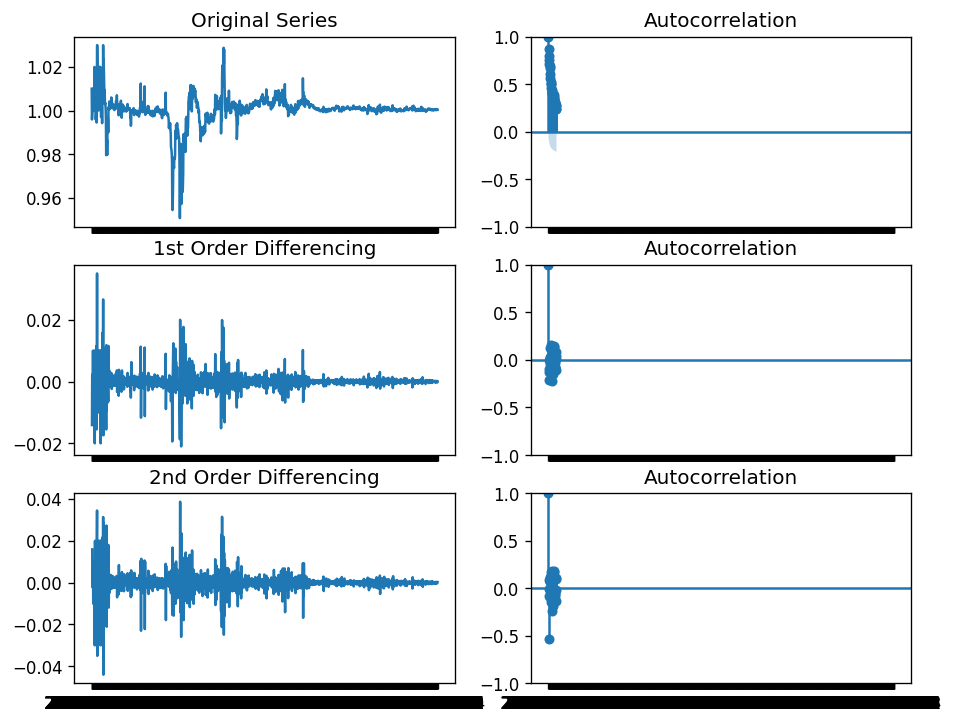

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(train); axes[0, 0].set_title('Original Series')
plot_acf(train, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

### Find the order of the AR term (p)

- The next step is to identify if the model needs any AR terms. We will find out the required number of AR terms by inspecting the **Partial Autocorrelation (PACF) plot.**
- **Partial autocorrelation** can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. This way, we will know if that lag is needed in the AR term or not.
- Now, we should find the number of AR terms. Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


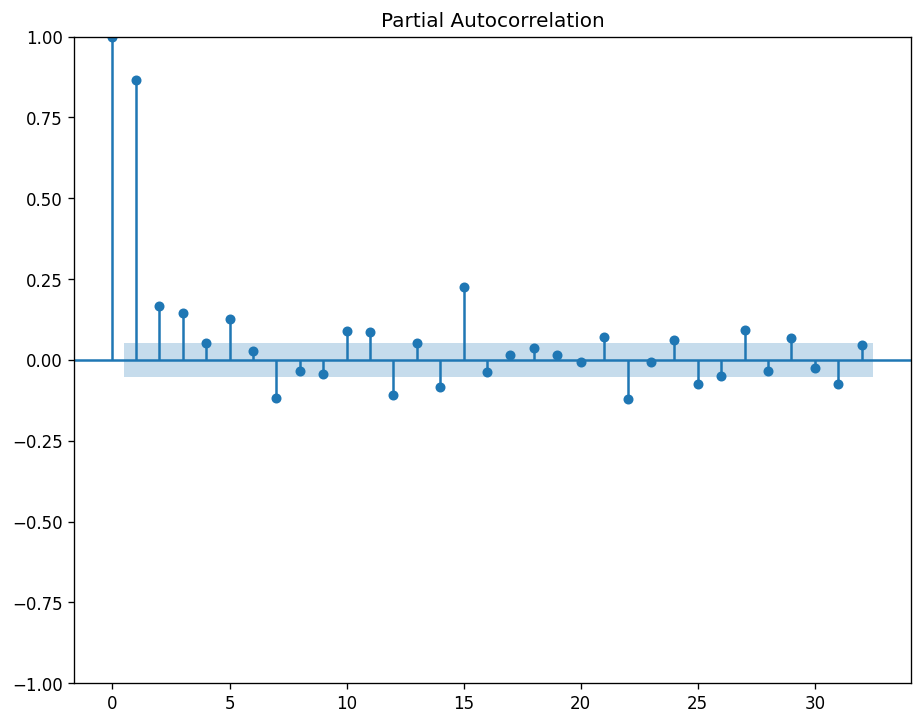

In [6]:
plot_pacf(train.dropna())
plt.show()

- We can see that the PACF lag < 5 are quite significant since it is well above the significance line. So, we will fix the value of p as 5.

### Find the order of the MA term (q)

- Just like how we looked at the PACF plot for the number of AR terms, we will look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.
- The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.
- Let’s see the autocorrelation plot of the series.

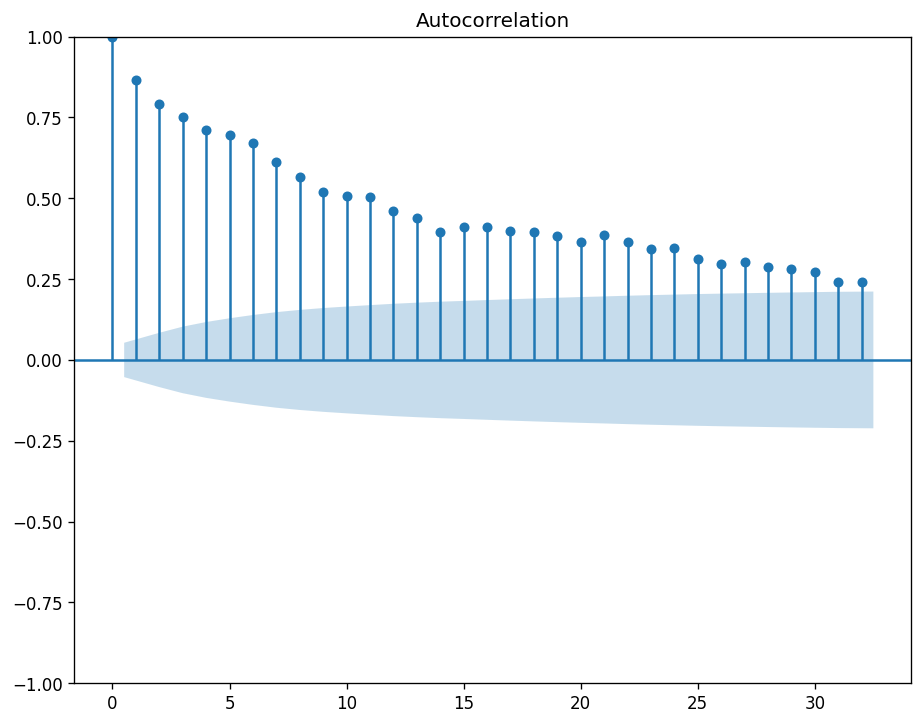

In [33]:
plot_acf(train.dropna())
plt.show()

- We can see that the ACF lag < 5 are quite significant since it is well above the significance line. So, we will fix the value of q as 5.

### Build the ARIMA Model

In [7]:
from statsmodels.tsa.arima.model import ARIMA

# 5,0,5 ARIMA Model
model = ARIMA(train, order=(1,0,2))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1362
Model:                 ARIMA(1, 0, 2)   Log Likelihood                5888.000
Date:                Tue, 02 May 2023   AIC                         -11765.999
Time:                        19:48:41   BIC                         -11739.916
Sample:                             0   HQIC                        -11756.235
                               - 1362                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0003      0.001    918.580      0.000       0.998       1.002
ar.L1          0.9526      0.005    187.338      0.000       0.943       0.963
ma.L1         -0.2626      0.013    -19.787      0.0

### 11. Find the optimal ARIMA model

C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


DatetimeIndex(['2021-08-25', '2021-08-26', '2021-08-27', '2021-08-28',
               '2021-08-29', '2021-08-30', '2021-08-31', '2021-09-01',
               '2021-09-02', '2021-09-03',
               ...
               '2023-03-23', '2023-03-24', '2023-03-25', '2023-03-26',
               '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30',
               '2023-03-31', '2023-04-01'],
              dtype='datetime64[ns]', name='Date', length=585, freq=None)


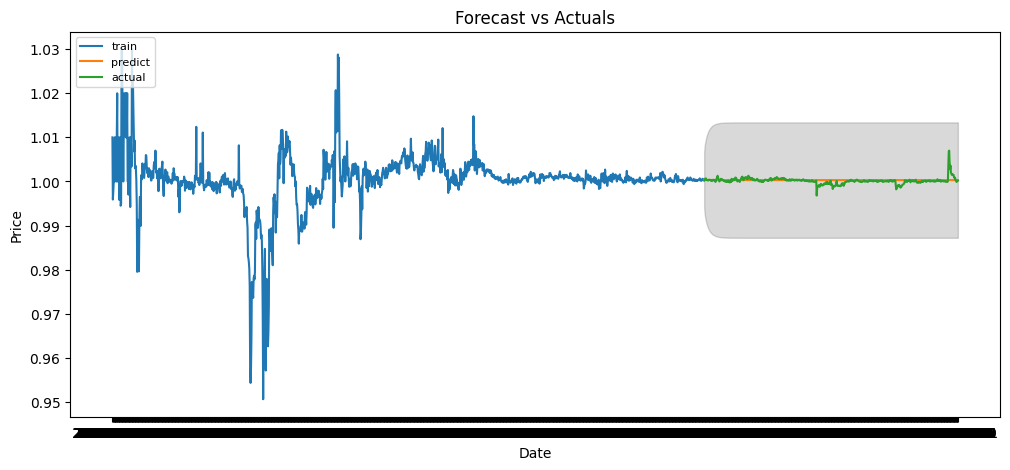

In [50]:
# Forecast
predict_results = model_fit.get_forecast(585)

# Confidence
conf = predict_results.conf_int(alpha=0.05)

# Make as pandas series
predict = pd.Series(predict_results.predicted_mean.values, index=test.index)
lower = pd.Series(conf['lower Price'].values, index=test.index)
upper = pd.Series(conf['upper Price'].values, index=test.index)

date = pd.Series()
date = date[(len(date)-len(test)):]
print(date)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='train')
plt.plot(predict, label='predict')
plt.plot(test, label='actual')
plt.fill_between(lower.index, lower, upper, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [51]:
#MAPE
def mean_absolute_percentage_error(predict, actual):
    return np.mean(np.abs(predict - actual)/np.abs(actual))

mean_absolute_percentage_error(predict, test['Price'])

0.0004200786309264163

In [14]:
#MAE

from sklearn.metrics import mean_absolute_error
mean_absolute_error(test['Price'], predict)

0.00042020880033603116

In [39]:
#MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(test['Price'], predict)

5.328105955115118e-07

### 2. SARIMAX Model

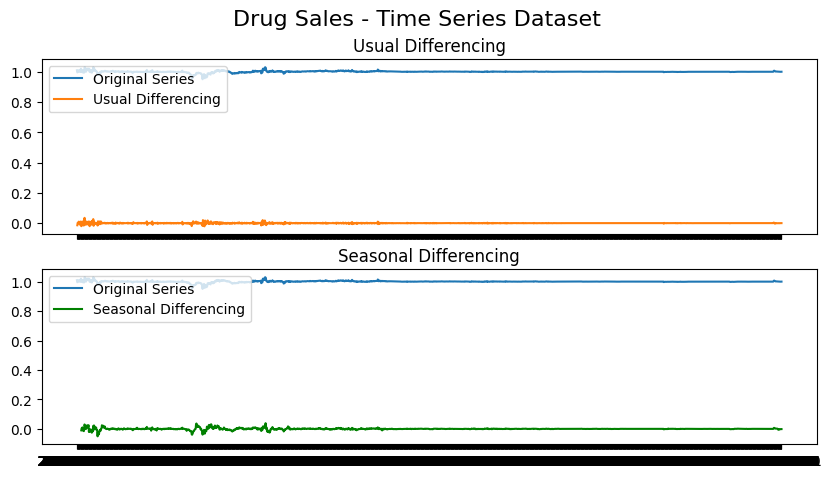

In [45]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df[:], label='Original Series')
axes[0].plot(df[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(df[:], label='Original Series')
axes[1].plot(df[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Drug Sales - Time Series Dataset', fontsize=16)
plt.show()

- Now, let’s build the SARIMA model using pmdarima‘s auto_arima(). To do so, we need to set seasonal=True, set the frequency m=12 for month wise series and enforce D=1.

In [47]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pmd.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-11250.862, Time=5.85 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-9624.032, Time=0.61 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-11167.070, Time=6.36 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-10615.909, Time=4.60 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-9625.977, Time=0.18 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-10737.082, Time=2.60 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-11229.075, Time=2.90 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=-11265.275, Time=17.67 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=-11239.144, Time=24.48 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=-10702.796, Time=28.37 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=-11436.226, Time=18.30 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-11204.118, Time=4.76 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=-11179.965, Time=20.11 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-11193.704, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 1362
Model:             SARIMAX(1, 0, 1)x(2, 1, [1, 2], 12)   Log Likelihood                5782.952
Date:                                 Wed, 03 May 2023   AIC                         -11551.903
Time:                                         01:11:24   BIC                         -11515.448
Sample:                                              0   HQIC                        -11538.251
                                                - 1362                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8707      0.009    101.395      0.000       0.854       0.888
ma.L1         -0.1041      0.016     -6.342      0.000      -0.136      -0.072
ar.S.L12      -0.5649      0.463     -1.221      0.222      -1.472       0.342
ar.S.L24      -0.1127      0.091     -1.238      0.216      -0.291       0.066
ma.S.L12      -0.4082      0.460     -0.887      0.375      -1.310       0.494
ma.S.L24      -0.2436      0.355     -0.687      0.492      -0.939       0.451
sigma2      1.099e-05   1.67e-07     65.929      0.000    1.07e-05    1.13e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):             13336.03
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


TypeError: tz must be string or tzinfo subclass.

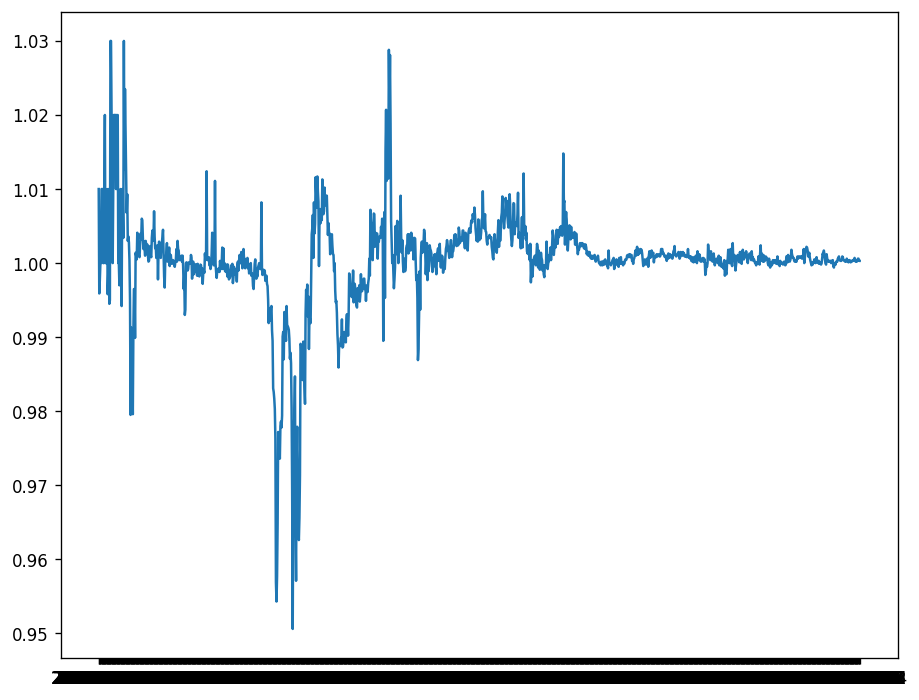

In [54]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Drug Sales - Time Series Dataset")
plt.show()